In [1]:
# To install matlab, run pip install matlab
# To install matlab engine, run pip install 'matlabengine == 9.13.7'

import numpy as np
import torch
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

from Models import BG

import os
os.makedirs("estimates", exist_ok=True)


True
NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
# 1) Build one BG instance
bg = BG(N=2**14, B=300000,batch_size=256,save_path="estimates/spy_theta.npy")

# initial_theta = [ [0.65826613, 1.75060141, 0.76696903, 5.26964855], [0.21481821, 3.72379017, 0.18812326, 5.64378929] ]
# initial_theta = [ [0.0075, 1.55, 0.0181, 0.6308], [0.0075, 1.55, 0.0181, 0.6308] ]

# 2) Fit theta over all time with batching
print("Fitting theta in batches...")
try:
    initial_theta = loadmat("estimates/spy_theta_500_NBT.mat")["theta"]
except FileNotFoundError:
    initial_theta = [[0.0075, 1.55, 0.0181, 0.6308]]
bg.fit_theta_in_batches(verbose=True, max_iter = 500, backtracking=True, initial_theta=None)
theta_spy = bg.all_params

print("Final theta shape:", theta_spy.shape)
print("Example SPY params at t=150:", theta_spy[0])

Fitting theta in batches...
[   0: 256] Adam Loss = 0.028522 Total steps = 500
[ 256: 512] Adam Loss = 0.014057 Total steps = 500
[ 512: 768] Adam Loss = 0.035658 Total steps = 500
[ 768:1024] Adam Loss = 0.013142 Total steps = 500
[1024:1280] Adam Loss = 0.027207 Total steps = 500
[1280:1536] Adam Loss = 0.015722 Total steps = 500
[1536:1792] Adam Loss = 0.046899 Total steps = 500
[1792:2048] Adam Loss = 0.042318 Total steps = 500
[2048:2304] Adam Loss = 0.028025 Total steps = 500
[2304:2560] Adam Loss = 0.018692 Total steps = 500
[2560:2816] Adam Loss = 0.022535 Total steps = 500
[2816:3072] Adam Loss = 0.021431 Total steps = 500
[3072:3328] Adam Loss = 0.029499 Total steps = 500
[3328:3584] Adam Loss = 0.045674 Total steps = 500
[3584:3840] Adam Loss = 0.037845 Total steps = 500
[3840:4096] Adam Loss = 0.035858 Total steps = 500
[4096:4330] Adam Loss = 0.037144 Total steps = 500
Final theta shape: (4330, 4)
Example SPY params at t=150: [0.00216513 1.54482508 0.00463692 0.63321126]


In [3]:
maxT = theta_spy.shape[0]
print("Example SPY params at t=150:", theta_spy[:min(5, maxT)])
#np.save('estimates/params_spy.npy', theta_spy)


Example SPY params at t=150: [[0.00216513 1.54482508 0.00463692 0.63321126]
 [0.00215324 1.54474294 0.00470125 0.63331127]
 [0.00216253 1.54480386 0.0045908  0.63324624]
 [0.00216589 1.54481936 0.00459935 0.63318288]
 [0.00215443 1.54474366 0.00468777 0.63330191]]


In [4]:
import matplotlib.pyplot as plt
import torch

def plot_bg_pdfs(bg_model, theta_batch, pdfs=None):
    """
    Plot a batch of BG PDFs.
    
    Parameters:
    - bg_model: the BG model object (already instantiated)
    - theta_batch: torch.Tensor of shape (B, 4)
    - pdfs: optional, precomputed tensor of shape (B, N)
    """
    B = theta_batch.shape[0]

    if pdfs is None:
        pdfs = bg_model.pdf(theta_batch)

    x = bg_model.x.cpu().numpy() if isinstance(bg_model.x, torch.Tensor) else bg_model.x

    for i in range(B):
        theta = theta_batch[i].cpu().numpy()
        label = f"bp={theta[0]:.2e}, cp={theta[1]:.2e}, bn={theta[2]:.2e}, cn={theta[3]:.2e}"

        plt.figure(figsize=(8, 4))
        plt.plot(x, pdfs[i].cpu().numpy(), label=label)
        plt.title(f'BG PDF Estimate - Sample {i}')
        plt.xlabel('Return')
        plt.ylabel('Density')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


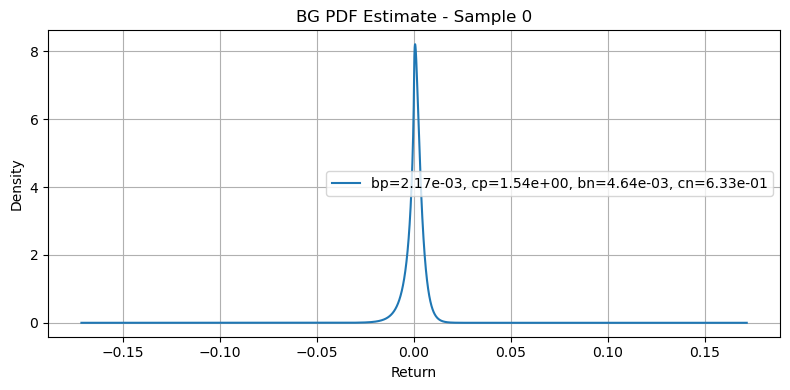

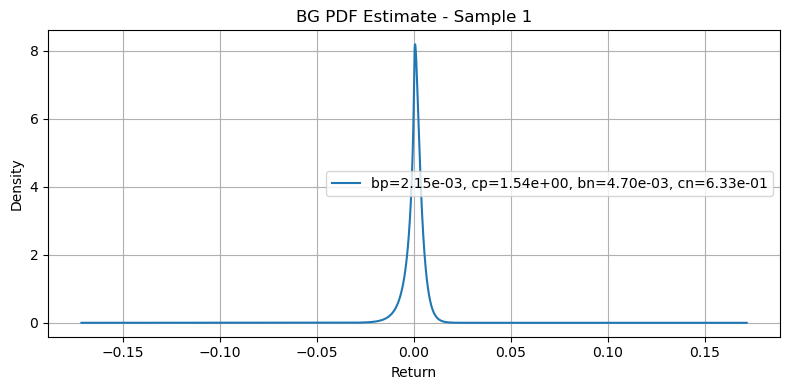

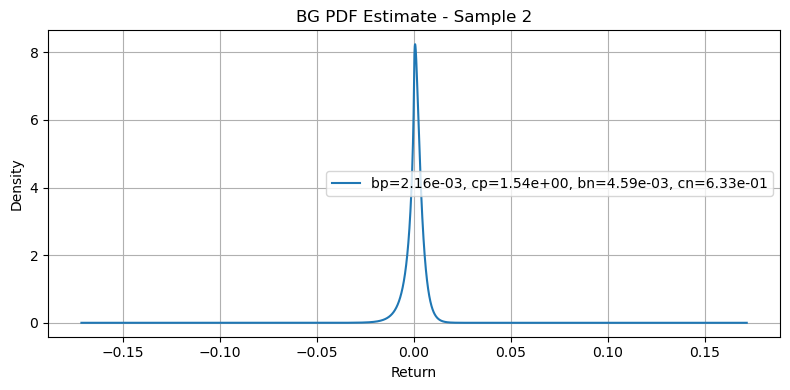

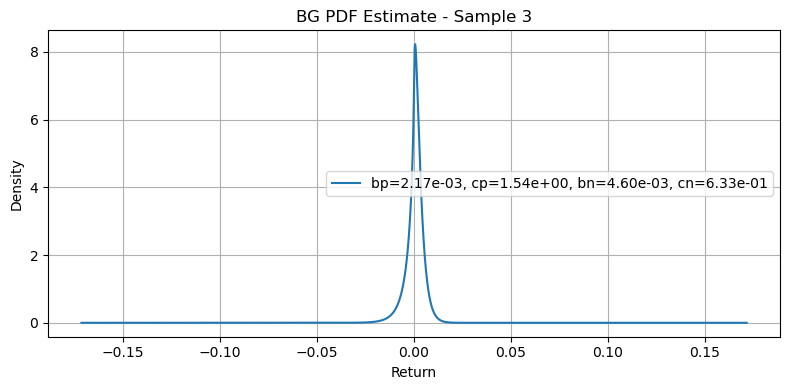

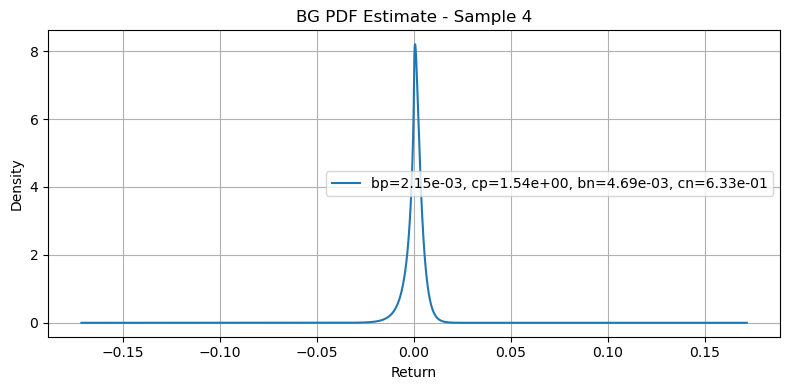

In [5]:
theta_batch = torch.tensor(theta_spy[:min(5,maxT)], dtype=torch.float32).to('cuda')
pdfs = bg.pdf(theta_batch)  # Expected shape: [5, 4096]

plot_bg_pdfs(bg, theta_batch, pdfs)

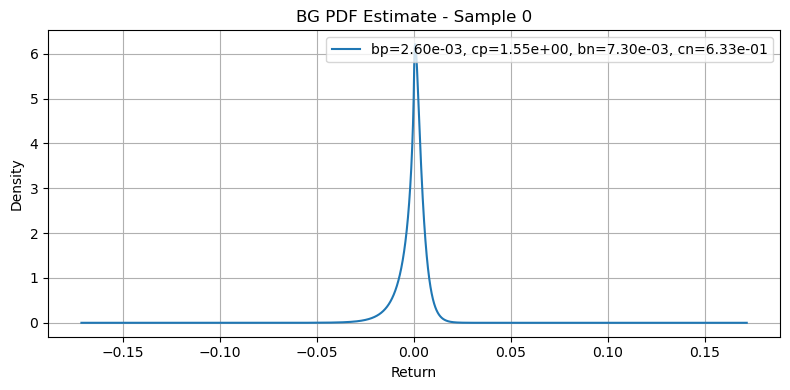

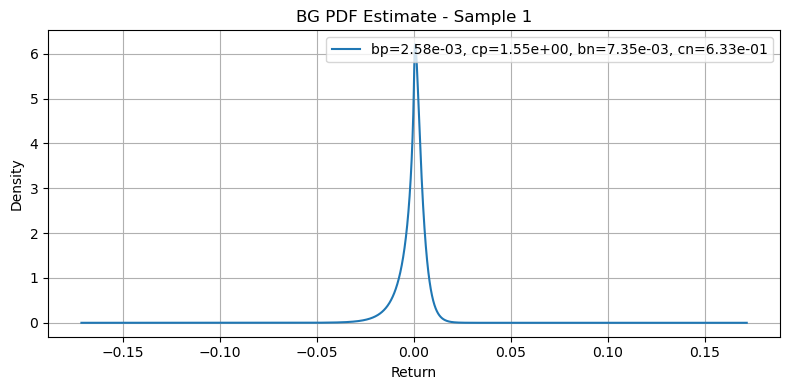

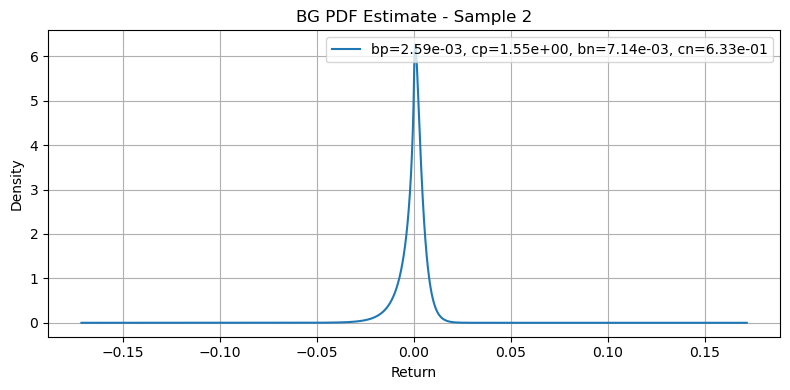

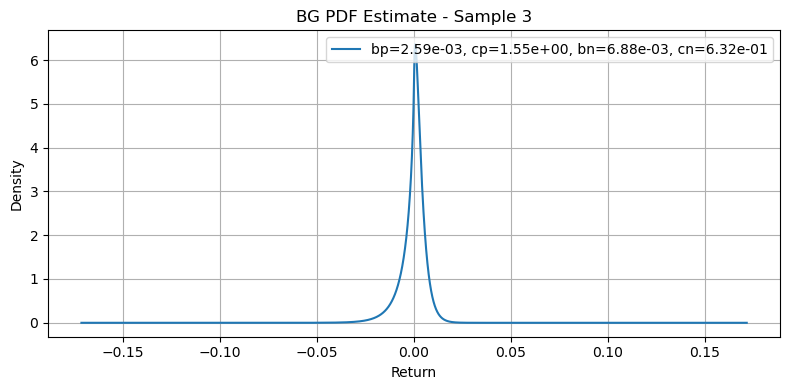

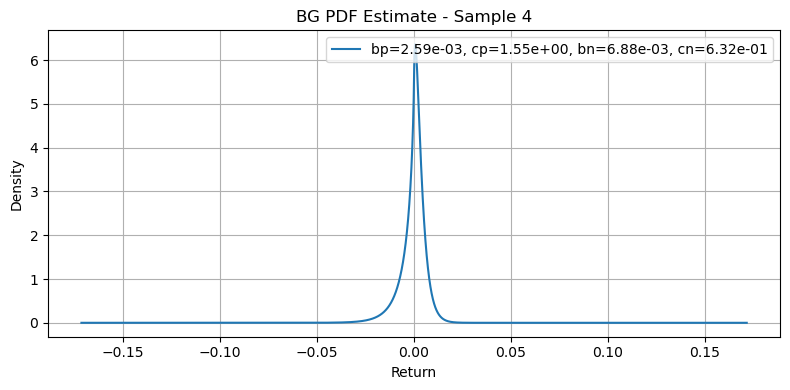

In [6]:
theta_batch = torch.tensor(theta_spy[max(maxT-5,0):maxT], dtype=torch.float32).to('cuda')
pdfs = bg.pdf(theta_batch)  # Expected shape: [5, 4096]

plot_bg_pdfs(bg, theta_batch, pdfs)

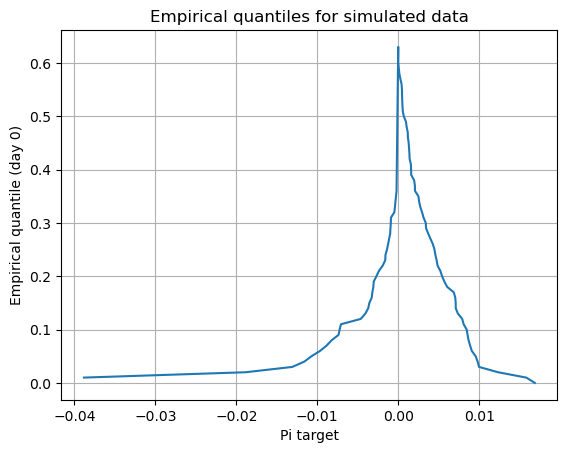

In [7]:
s_batch = bg.s_batch.detach().clone()

# Example: plot Day 0
import matplotlib.pyplot as plt
plt.plot(s_batch[0].to('cpu').numpy(), bg.Pi_target[0], label='Empirical quantiles (day 0)')
plt.xlabel('Pi target')
plt.ylabel('Empirical quantile (day 0)')
plt.title('Empirical quantiles for simulated data')
plt.grid()
plt.show()


In [8]:
import matplotlib.pyplot as plt
import torch
import random

def plot_empirical_vs_theoretical(bg, theta_spy, n=3, seed=42, days=None):
    """
    Plots empirical vs theoretical CDFs for `n` randomly selected days.
    Now splits upper and lower tails into separate subplots.
    """
    s_batch = bg.s_batch          # shape (T, K)
    Pi_target = bg.Pi_target    # shape (T,K)
    cal_days = bg.days          # List of calibration days

    if days is None:
        days = range(len(cal_days))
    
    n = min(n, len(days))  # Ensure n does not exceed available days
    if n == len(days):
        days = [days[i] for i in range(len(days))]  # Use all days if n >= # available days
    else:
        random.seed(seed)
        days = [days[i] for i in random.sample(range(len(days)), n)]
    days_0 = [day - days[0] for day in days]

    theta_batch = torch.tensor(theta_spy[days_0], dtype=torch.float32).to(bg.device)
    Q_model = bg.theoretical_quantiles(theta_batch, s_batch[days_0])  # shape (n, K)

    K = len(Pi_target)

    for i, day in enumerate(days):
        s = s_batch[day - days[0]].cpu().numpy()
        pi_emp = Pi_target[day - days[0]]
        pi_model = Q_model[i].detach().cpu().numpy()

        plt.plot(s, pi_emp, label='Empirical tails')
        plt.plot(s, pi_model, label='Theoretical tails')
        plt.title(f'Tails Fitting (day {cal_days[day]})')
        plt.xlabel('s')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

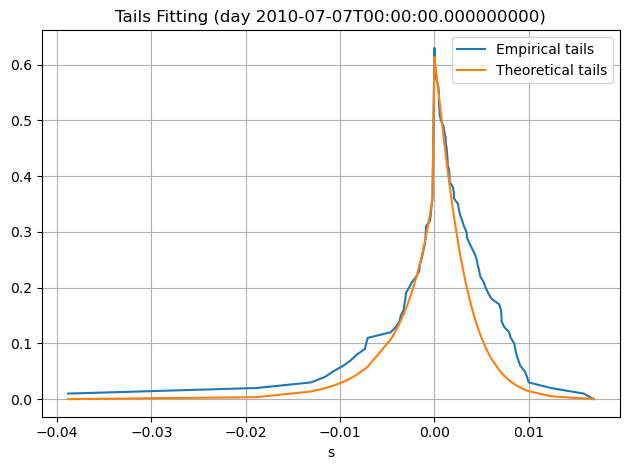

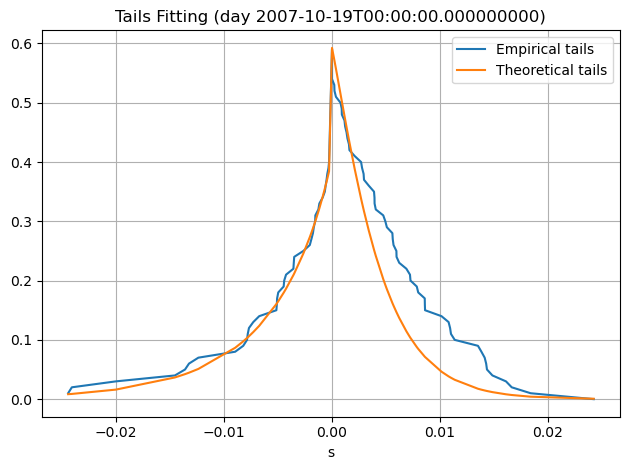

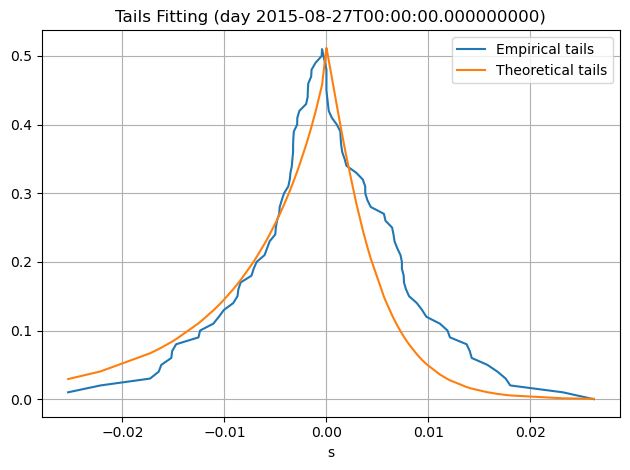

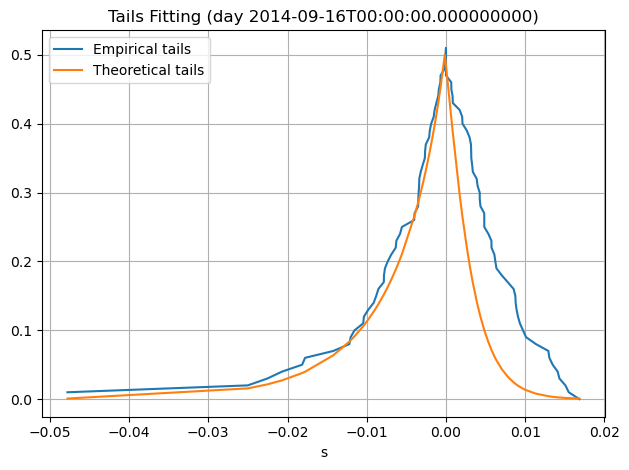

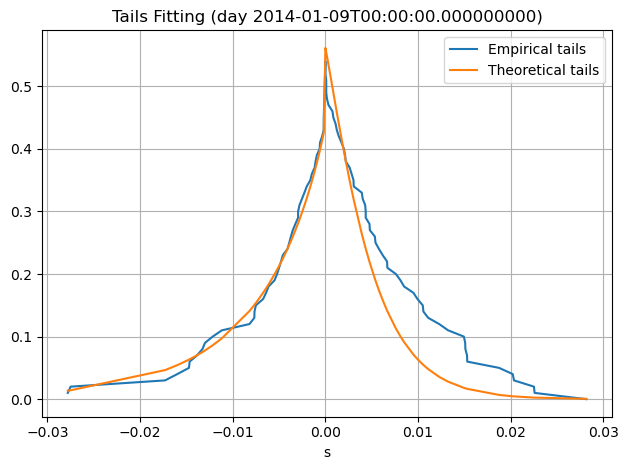

In [9]:
idx = range(4330)
plot_empirical_vs_theoretical(bg, theta_spy, n=5, days=idx)

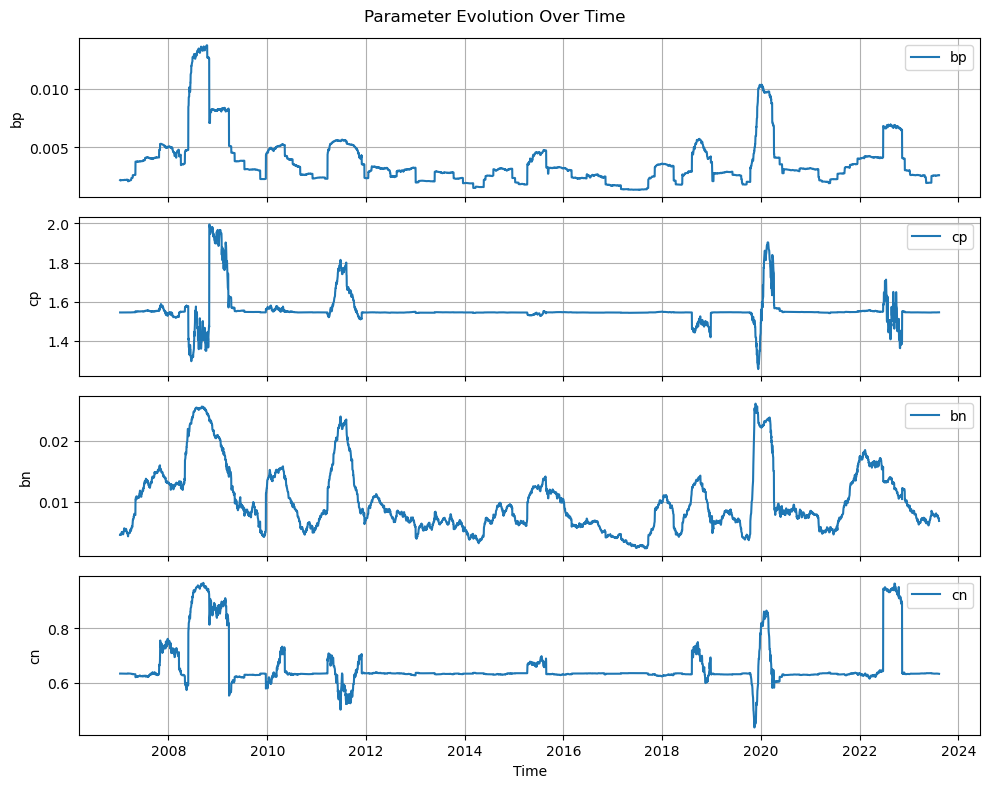

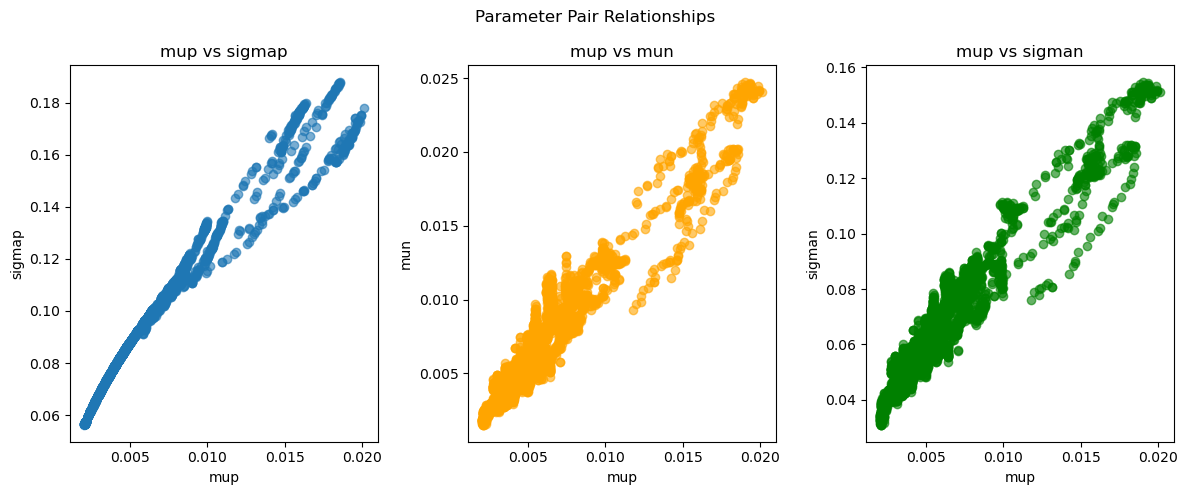

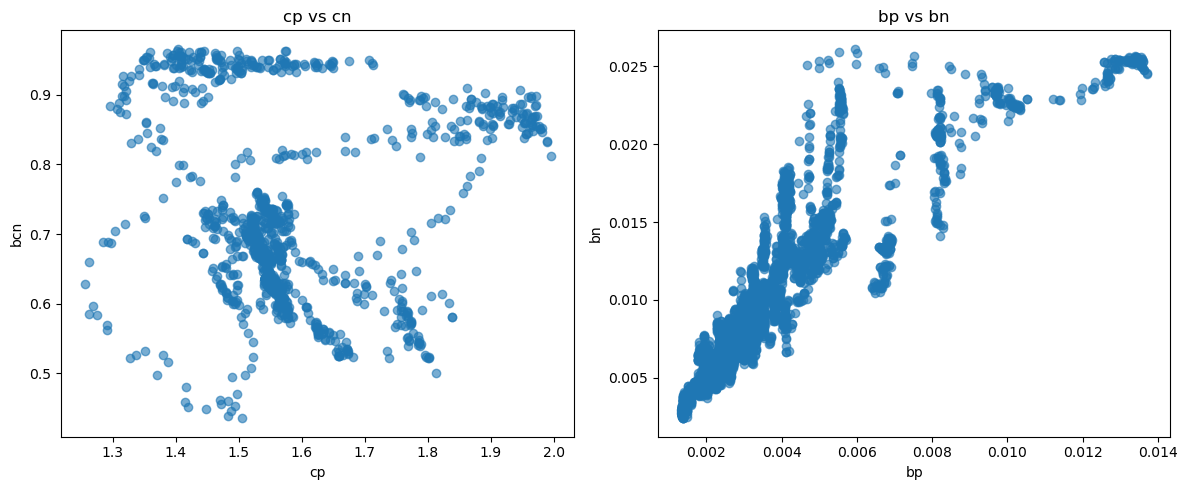

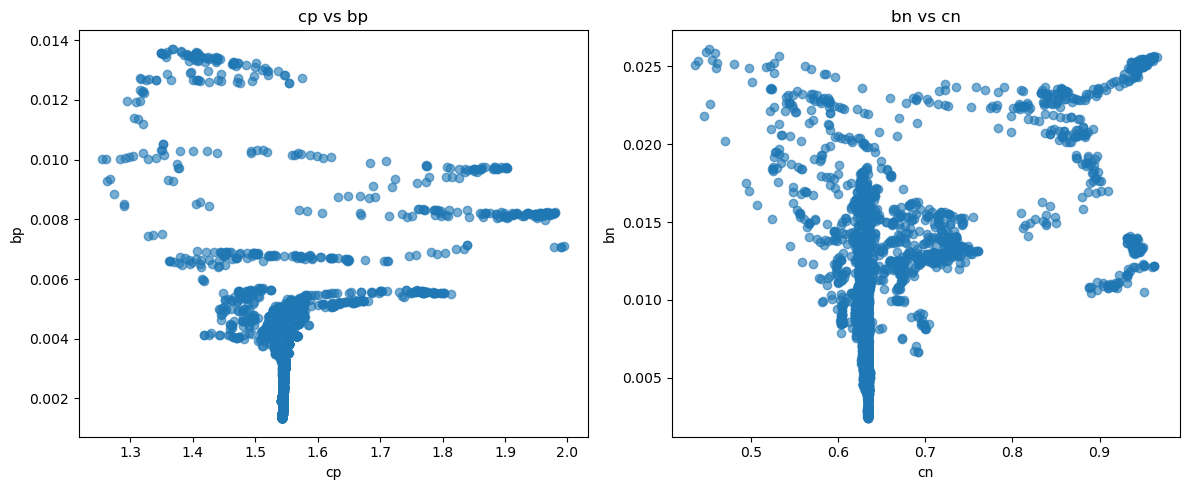

In [10]:
idx_0 = [id-idx[0] for id in idx]
bp, cp, bn, cn = theta_spy[idx_0].T
T = bg.days[idx_0]

# 1. Plot each parameter over time
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
params = ['bp', 'cp', 'bn', 'cn']
for i, param in enumerate([bp, cp, bn, cn]):
    axs[i].plot(T, param, label=params[i])
    axs[i].set_ylabel(params[i])
    axs[i].legend()
    axs[i].grid(True)
axs[-1].set_xlabel('Time')
plt.suptitle('Parameter Evolution Over Time')
plt.tight_layout()
plt.show()

# 2. Plot parameter pairs: (mup, sigmap) and (mun, sigman)
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].scatter(bp*cp, np.sqrt(bp)*cp, alpha=0.6)
ax[0].set_xlabel('mup')
ax[0].set_ylabel('sigmap')
ax[0].set_title('mup vs sigmap')

ax[1].scatter(bp*cp, bn*cn, alpha=0.6, color='orange')
ax[1].set_xlabel('mup')
ax[1].set_ylabel('mun')
ax[1].set_title('mup vs mun')

ax[2].scatter(bp*cp, np.sqrt(bn)*cn, alpha=0.6, color='green')
ax[2].set_xlabel('mup')
ax[2].set_ylabel('sigman')
ax[2].set_title('mup vs sigman')

plt.suptitle('Parameter Pair Relationships')
plt.tight_layout()
plt.show()

# 3. Plot parameter pairs: (bp, bn) and (cp, cn)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(cp, cn, alpha=0.6)
ax[0].set_xlabel('cp')
ax[0].set_ylabel('bcn')
ax[0].set_title('cp vs cn')

ax[1].scatter(bp, bn, alpha=0.6)
ax[1].set_xlabel('bp')
ax[1].set_ylabel('bn')
ax[1].set_title('bp vs bn')

plt.tight_layout()
plt.show()

# 3. Plot parameter pairs: (bp, bn) and (cp, cn)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(cp, bp, alpha=0.6)
ax[0].set_xlabel('cp')
ax[0].set_ylabel('bp')
ax[0].set_title('cp vs bp')

ax[1].scatter(cn, bn, alpha=0.6)
ax[1].set_xlabel('cn')
ax[1].set_ylabel('bn')
ax[1].set_title('bn vs cn')

plt.tight_layout()
plt.show()


In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_per_day(bg, logscale=False):
    """
    Plot per-day loss using BG.batch_losses and BG.days.

    Parameters
    ----------
    bg : instance of BG class
        Must contain attributes:
        - batch_losses: (T,) array of losses
        - fit_day_indices: list of indices into bg.days
        - days: full list of datetime64 days
    logscale : bool
        If True, plot y-axis on log scale
    """
    assert hasattr(bg, 'batch_losses') and hasattr(bg, 'fit_day_indices') and hasattr(bg, 'days')

    # Map fit_day_indices to actual calendar days
    day_labels = pd.to_datetime(bg.days[bg.fit_day_indices])
    
    # Build plot
    plt.figure(figsize=(10, 4))
    plt.plot(day_labels, bg.batch_losses, marker='.', linestyle='-', alpha=0.8)
    plt.xlabel("Date")
    plt.ylabel("Loss per day")
    if logscale:
        plt.yscale("log")
        plt.ylabel("Loss per day (log)")
    plt.title("Anderson-Darling Loss Per Day")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


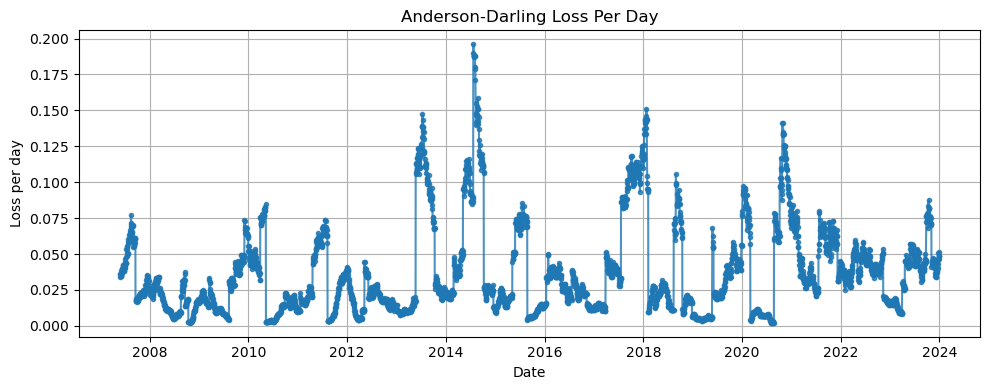

Average loss per day: 0.0373
Max loss per day: 0.1960
Day with max loss: 2014-07-24T00:00:00.000000000


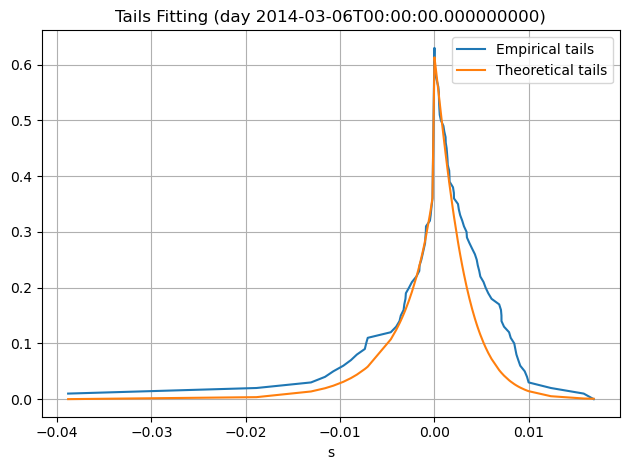

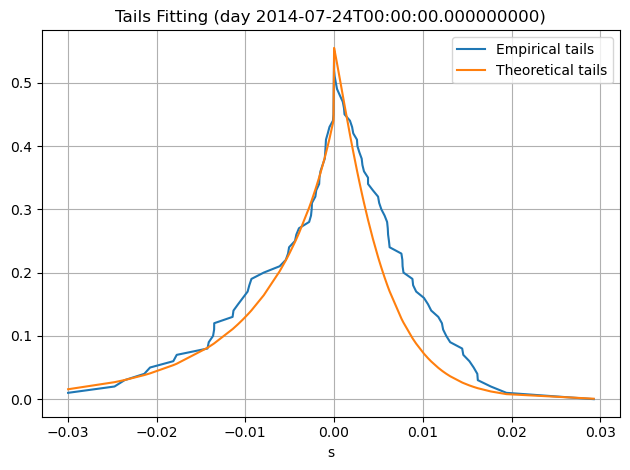

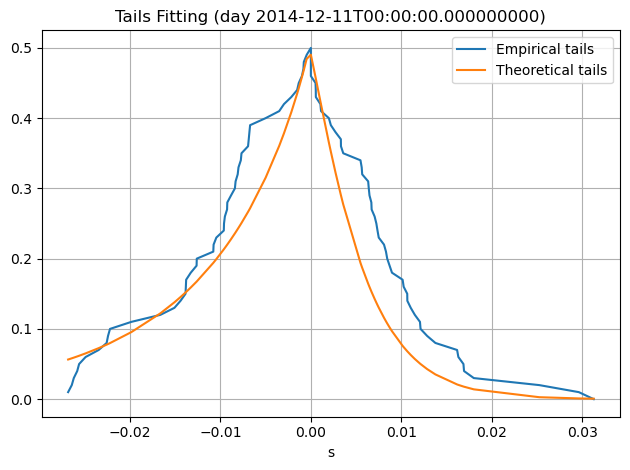

In [12]:
plot_loss_per_day(bg)
print(f"Average loss per day: {bg.batch_losses.mean():.4f}")
print(f"Max loss per day: {bg.batch_losses.max():.4f}")
print(f"Day with max loss: {bg.days[bg.fit_day_indices][bg.batch_losses.argmax()]}")

# Plot empirical vs theoretical quantiles for SPY on day with max loss
idx_worst = bg.batch_losses.argmax()+bg.window
idx = [idx_worst-100,idx_worst,idx_worst+100]
plot_empirical_vs_theoretical(bg, theta_spy, n=3, days=idx)